# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import lightgbm as lgb
import nltk
import numpy as np
import pandas as pd
import re
import torch
import transformers

from catboost import CatBoostClassifier

from gensim.parsing.preprocessing import remove_stopwords

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

from nltk.corpus import stopwords
from nltk.corpus import wordnet

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

from tqdm.autonotebook import tqdm
tqdm.pandas()

from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline


In [2]:
df_tweets = pd.read_csv('toxic_comments.csv')

In [3]:
df_tweets.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Удаляем лишний столбец

In [5]:
df_tweets = df_tweets[['text', 'toxic']]

Проверим дисбаланс классов целевого признака

In [6]:
df_tweets.toxic.mean()

0.10161213369158527

**Вывод:** В данных почти 160000 строк. Из них негативные только 10%.

## Обучение

### Обучение моделей с BERT

#### Для экономии времени возьмем из наших данных 2000 объектов сохранив исходный дисбаланс класов целевого признака

In [7]:
df_tweets_sample, _ = train_test_split(df_tweets, train_size=200, random_state=12345, stratify=df_tweets.toxic)

In [8]:
df_tweets_sample.shape

(200, 2)

In [9]:
df_tweets_sample.toxic.mean()

0.1

#### Используем предобученную модель с домена https://huggingface.co/martin-ha/toxic-comment-model
Не создаем эмбердинги, а сразу получаем предсказания модели.

In [10]:
model_path = "martin-ha/toxic-comment-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

pipeline =  TextClassificationPipeline(model=model, tokenizer=tokenizer)

y_pred = []
for text in tqdm(df_tweets_sample['text']):
    pred = pipeline(text[:512])
    y_pred.append(1 if pred[0]['label'] == 'toxic' else 0)

  0%|          | 0/200 [00:00<?, ?it/s]

In [11]:
f1_score(df_tweets_sample['toxic'], y_pred)

0.7272727272727274

Очень быстрый результат, но метрика ниже заданного порога.

#### Используем предобученную модель Conversational BERT, English с домена <a href='https://docs.deeppavlov.ai/en/master/features/models/bert.html'> DeepPavlov</a> для векторизации

In [12]:
tokenizer_config = transformers.BertConfig.from_json_file(
    'ds_bert/tokenizer_config.json')

tokenizer = transformers.BertTokenizer(
    vocab_file='ds_bert/vocab.txt', config=tokenizer_config)

tokenized = df_tweets_sample['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))

max_len = len(max(tokenized, key=len))

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [13]:
config = transformers.BertConfig.from_json_file(
    'ds_bert/config.json')
model = transformers.BertModel.from_pretrained(
    'ds_bert/pytorch_model.bin', config=config)

Some weights of the model checkpoint at ds_bert/pytorch_model.bin were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
padded.shape

(200, 512)

In [17]:
batch_size = 2
embeddings = []
for i in tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
features = np.concatenate(embeddings)
features.shape

(200, 768)

**Модели LGBMClassifier и LogisticRegression**

In [43]:
%%time

model_lgb = lgb.LGBMClassifier(metric='f1', objective='binary', is_unbalance=True)
model_lr = LogisticRegression(random_state=12345, class_weight='balanced')

pipe = Pipeline([('regressor', model)])

param_grid = [
    {'regressor': [model_lgb],
     'regressor__max_depth': [10],              
     'regressor__learning_rate': np.arange(0.1, 1, 0.1),
     'regressor__n_estimators': [2000]},
    {'regressor': [model_lr]}
]

model_lgbm_bert = GridSearchCV(
    pipe,
    param_grid,
    cv=scv,
    scoring='f1',
    n_jobs = -1)

model_lgbm_bert.fit(features, df_tweets_sample['toxic'])


print(model_lgbm_bert.best_params_)
print(model_lgbm_bert.best_score_)

{'regressor': LogisticRegression(class_weight='balanced', random_state=12345)}
0.6542857142857142
CPU times: total: 234 ms
Wall time: 7.84 s


C:\123\WPy64-31090\python-3.10.9.amd64\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
bert_result = (pd.DataFrame(model_lgbm_bert.cv_results_)
  [['params', 'mean_test_score', 'rank_test_score', 'mean_fit_time', 'mean_score_time']]
  .sort_values(by='mean_test_score', ascending=False)
  .head()).reset_index(drop=True)
bert_result

,params,mean_test_score,rank_test_score,mean_fit_time,mean_score_time
0,{'regressor': LogisticRegression(class_weight=...,0.654286,1,0.040089,0.002362
1,{'regressor': LGBMClassifier(is_unbalance=True...,0.579048,2,2.996058,0.004032
2,{'regressor': LGBMClassifier(is_unbalance=True...,0.521905,3,2.483533,0.001607
3,{'regressor': LGBMClassifier(is_unbalance=True...,0.499048,4,2.158290,0.004028
4,{'regressor': LGBMClassifier(is_unbalance=True...,0.432381,5,1.930929,0.004825


In [128]:
result = {'LGBMClassifier':[], 'LogisticRegression':[]}

In [129]:
result['LGBMClassifier'].append(bert_result['mean_test_score'][1].round(3))

In [130]:
result['LogisticRegression'].append(bert_result['mean_test_score'][0].round(3))

**Вывод** Лучший результат у LogisticRegression. Но все же он намного ниже требуемого. Возможно с увеличением количества объектов увеличится и качество модели. 

### Обучение моделей с TF-IDF и CountVectorizer

#### Лемматизация текста

In [53]:
def get_wordnet_pos_new(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [54]:
%%time

nltk.download('popular')


def text_transform(text):
    #удаляем неалфавитные символы
    text = re.sub("[^a-zA-Z]"," ",text) 
    # токенизируем слова
    text = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(text)
    # лемматирзируем слова
    text = [lemmatize.lemmatize(word, get_wordnet_pos_new(tag)) for word, tag in pos_tags] 
            #if not word in set(stopwords.words('english'))]
    # соединяем слова
    text = " ".join(text)
    return text

lemmatize = nltk.WordNetLemmatizer()
df_tweets['text'] = df_tweets['text'].progress_apply(remove_stopwords)
df_tweets['lemm_text'] = df_tweets['text'].progress_apply(text_transform)

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\Виталик\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\Виталик\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\Виталик\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\Виталик\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\Виталик\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nlt

  0%|          | 0/159292 [00:00<?, ?it/s]

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: total: 7min 29s
Wall time: 7min 29s


In [55]:
df_tweets.head()

,text,toxic,lemm_text
0,Explanation Why edits username Hardcore Metall...,0,Explanation Why edits username Hardcore Metall...
1,D'aww! He matches background colour I'm seemin...,0,D aww He match background colour I m seemingly...
2,"Hey man, I'm trying edit war. It's guy constan...",0,Hey man I m try edit war It s guy constantly r...
3,""" More I can't real suggestions improvement - ...",0,More I can t real suggestion improvement I won...
4,"You, sir, hero. Any chance remember page that'...",0,You sir hero Any chance remember page that s on


#### Разделим наши данные на train/test

In [56]:
X_train, X_test, y_train, y_test = train_test_split(df_tweets['lemm_text'], df_tweets['toxic'],
                                                    test_size=.2,
                                                    random_state=12345,
                                                    stratify=df_tweets.toxic)

In [57]:
tfidf_vectorizer = TfidfVectorizer()

In [58]:
count_vect = CountVectorizer(dtype=np.float32) 

#### Подбор гиперпараметров и обучение моделей LogisticRegression и LGBMClassifier

In [60]:
%%time


model = LogisticRegression(random_state=12345, class_weight='balanced')
model_lgb = lgb.LGBMClassifier(metric='f1',                               
                               objective='binary'                               
                               )


pipe = Pipeline(
    [('vect', tfidf_vectorizer),
    ('regressor', model)]
)

param_grid = [{'vect':[tfidf_vectorizer, count_vect],
              'regressor': [model],
              'regressor__C': range(1, 20, 1)},
              {'vect':[tfidf_vectorizer, count_vect],
              'regressor': [model_lgb],
              'regressor__max_depth': [100],              
              'regressor__learning_rate': [.3],
              'regressor__n_estimators':  [600],
              'regressor__is_unbalance': [True],
              'regressor__reg_alpha': [.1]
             }
             ]
   

scv = StratifiedKFold(n_splits=5)

model_grid = GridSearchCV(
    pipe,
    param_grid,
    cv=scv,
    scoring='f1',
    n_jobs = -1
    )
model_grid.fit(X_train, y_train)



print(model_grid.best_params_)
print(model_grid.best_score_)

{'regressor': LGBMClassifier(is_unbalance=True, learning_rate=0.3, max_depth=100, metric='f1',
               n_estimators=600, objective='binary', reg_alpha=0.1), 'regressor__is_unbalance': True, 'regressor__learning_rate': 0.3, 'regressor__max_depth': 100, 'regressor__n_estimators': 600, 'regressor__reg_alpha': 0.1, 'vect': CountVectorizer(dtype=<class 'numpy.float32'>)}
0.7778393629047834
CPU times: total: 2min 43s
Wall time: 8min 20s


**Результаты**

In [101]:
vect_result = (pd.DataFrame(model_grid.cv_results_)
  [['param_regressor', 'param_vect', 'mean_test_score', 'rank_test_score', 'mean_fit_time', 'mean_score_time']]
   .sort_values(by='mean_test_score', ascending=False)
  ).reset_index(drop=True)
vect_result.head()

,param_regressor,param_vect,mean_test_score,rank_test_score,mean_fit_time,mean_score_time
0,"LGBMClassifier(is_unbalance=True, learning_rat...",CountVectorizer(dtype=<class 'numpy.float32'>),0.777839,1,76.192374,5.484644
1,"LGBMClassifier(is_unbalance=True, learning_rat...",TfidfVectorizer(),0.774050,2,224.143465,5.005721
2,"LogisticRegression(class_weight='balanced', ra...",TfidfVectorizer(),0.768352,3,14.457293,1.685853
3,"LogisticRegression(class_weight='balanced', ra...",TfidfVectorizer(),0.768107,4,13.656884,1.708761
4,"LogisticRegression(class_weight='balanced', ra...",TfidfVectorizer(),0.768052,5,14.293548,1.601098


In [121]:
vect_result.query('(param_vect==@tfidf_vectorizer) and (param_regressor==@model_lgb)').mean_test_score.max()

0.7740497821944208

**Сохраним результаты в итоговую таблицу**

In [131]:
(result['LGBMClassifier']
 .append(
     round(
         vect_result.query('(param_vect==@tfidf_vectorizer) and (param_regressor==@model_lgb)')
         .mean_test_score
         .max(), 3)
 )
)

(result['LGBMClassifier']
 .append(
     round(
         vect_result.query('(param_vect==@count_vect) and (param_regressor==@model_lgb)')
         .mean_test_score
         .max(), 3)
 )
)

(result['LogisticRegression']
 .append(
     round(
         vect_result.query('(param_vect==@tfidf_vectorizer) and (param_regressor==@model)')
         .mean_test_score
         .max(), 3)
 )
)


(result['LogisticRegression']
 .append(
     round(
         vect_result.query('(param_vect==@count_vect) and (param_regressor==@model)')
         .mean_test_score
         .max(), 3)
 )
)


**Выгружаем лучшую модель в файл**

In [123]:
import joblib
# save
joblib.dump(model_grid.best_estimator_, "model.pkl")
# load
#clf2 = joblib.load("model.pkl")
#clf2.predict(X[0:1])

['model.pkl']

In [132]:
pd.DataFrame.from_dict(result, orient='index', columns=['BERT', 'TF-IDF', 'CountVectorizer'])

,BERT,TF-IDF,CountVectorizer
LGBMClassifier,0.579,0.774,0.778
LogisticRegression,0.654,0.768,0.760


**Вывод:** Лучший результат показала LGBMClassifier c CountVectorizer. Проверим ее на тесте.

**Тестирование**

In [133]:
f1_score(y_test, model_grid.predict(X_test))

0.7870852551703617

**Проверим модель на адекватность**

In [134]:
f1_score(y_test, np.ones(len(y_test)))

0.18446546614998857

## Выводы

В выборке почти 160000 строк. Из них негативные только 10%.

**Обучение моделей с BERT**

Для экономии времени было взято 200 объектов сохранив исходный дисбаланс класов целевого признака.
Использовали предобученную модель Conversational BERT, English с домена <a href='https://docs.deeppavlov.ai/en/master/features/models/bert.html'> DeepPavlov</a>. Лучший результат у LogisticRegression, f1 = 0.626. Но все же он намного ниже требуемого. Возможно с увеличением количества объектов увеличится и качество модели.

**Обучение моделей с TF-IDF и CountVectorizer**

Для предподготовки текста использовали библиотеку nltk. Лучший результат показала LGBMClassifier c CountVectorizer, f1 = 0.778.

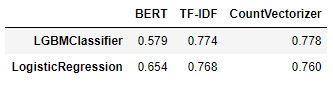

На тестовой выборке модель показала f1 = 0.787